In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.integrate import quad,dblquad

In [2]:
def model(w,phase,t):
    return np.sin(w*t+phase)

In [3]:
def generate_data(w,phase,t,sigma,rng):
    noise = rng.normal(0,sigma,size=len(t))
    return model(w,phase,t) + noise

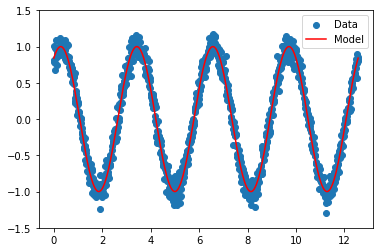

In [8]:
t = np.linspace(0,4*np.pi,1000)
rng = np.random.RandomState(seed=1)
plt.scatter(t,generate_data(2,1,t,0.1,rng), label="Data")
plt.plot(t,model(2,1,t),c="red", label="Model")
plt.ylim(-1.5,1.5)
plt.legend()
plt.savefig('Data_Model_plot.png')

In [5]:
root2pi = np.sqrt(2*np.pi)
logroot2pi = np.log(root2pi)

In [6]:
def neg_log_likelihood(w,phase,y_k,t,sigma):
    y = model(w,phase,t)
    return logroot2pi*len(t) + np.log(sigma)*len(t) + np.sum((y-y_k)**2, axis=-1) / (2*sigma**2)

In [7]:
def log_prior(w, phase, w_1, w_2, dist="flat", mu=2, sigma=1):
    if dist == "flat":
        p = 1/(2*np.pi) * 1/(w_2-w_1)
    if dist == "gaussian":
        p = 1/(root2pi * sigma) * np.exp(-(w-mu)**2) / (2*sigma**2)
    return np.log(p)

In [8]:
def evidence_integrand(w, phase, y_k, t, sigma, w_1, w_2, dist="flat"):
    return np.exp(-neg_log_likelihood(w,phase,y_k,t,sigma)+log_prior(w, phase, w_1, w_2, dist))

In [9]:
# testing evidence calculation
w_1 = 1
w_2 = 3
sigma = 0.1
phase = 1
t = np.linspace(0,2*np.pi,500)[[200,400]]
rng = np.random.RandomState(seed=1)
wp = rng.uniform(w_1, w_2)
y_k = generate_data(wp,phase,t,sigma,rng)
evidence, err = quad(evidence_integrand, w_1, w_2, args=(phase,y_k,t,sigma,w_1,w_2))
print(evidence,err)

0.05098572375623714 8.068094579373759e-09


In [10]:
def utility_integrand(w, phase, y_k, t, sigma, w_1, w_2, evidence):
    posterior = np.exp(-neg_log_likelihood(w,phase,y_k,t,sigma)+log_prior(w,phase,w_1,w_2))/evidence
    return np.log(posterior)*posterior

In [11]:
def prior_integrand(w, phase, w_1, w_2, dist="flat"):
    return log_prior(w, phase, w_1, w_2, dist)*np.exp(log_prior(w, phase, w_1, w_2, dist))

In [12]:
def Uy(phase, y_k, t, sigma, w_1, w_2, evidence, prior_integral):
    return -quad(utility_integrand, w_1, w_2, args=(phase,y_k,t,sigma,w_1,w_2,evidence))[0] + prior_integral

In [13]:
# testing Uy calculation
w_1 = 1
w_2 = 3
sigma = 0.1
phase = 1
i = [200,400]
t = np.linspace(0,2*np.pi,500)[i]
rng = np.random.RandomState(seed=1)
wp = rng.uniform(w_1, w_2)
y_k = generate_data(wp,phase,t,sigma,rng)
evidence = quad(evidence_integrand, w_1, w_2, args=(phase,y_k,t,sigma,w_1,w_2,"flat"))[0]
prior_integral = quad(prior_integrand, w_1, w_2, args=(phase,w_1,w_2,"flat"))[0]
Uy(phase,y_k,t,sigma,w_1,w_2,evidence,prior_integral)

-2.679141756901912

In [14]:
def utility(i, phase, Uy, sigma, w_1, w_2, N, seed=1, nmc=100):
    U_sum = 0.
    rng = np.random.RandomState(seed)
    t = np.linspace(0,2*np.pi,N)[i]
    prior_integral = quad(prior_integrand, w_1, w_2, args=(phase,w_1,w_2))[0]
    for i in range(nmc):
        # generate params from prior
        wp = rng.uniform(w_1, w_2)
        # generate data for these params
        y_k = generate_data(wp,phase,t,sigma,rng)
        # evalute per-data utility
        evidence = quad(evidence_integrand, w_1, w_2, args=(phase,y_k,t,sigma,w_1,w_2))[0]
        U_sum += Uy(phase,y_k,t,sigma,w_1,w_2,evidence,prior_integral)
    U_sum += prior_integral
    return U_sum / nmc

In [36]:
p = 40
N = 1000
x = np.linspace(0,N,p, endpoint=False)
y = np.linspace(0,N,p, endpoint=False)
x2D,y2D = np.meshgrid(x,y)
indices = np.stack((x2D,y2D),axis=2).reshape(-1,2).astype(int)
print(indices)

[[  0   0]
 [ 25   0]
 [ 50   0]
 ...
 [925 975]
 [950 975]
 [975 975]]


In [33]:
p = 10
N = 1000
s = 1
w_1 = 1
w_2 = 3
sigma = 0.1
phase = 1

x = np.linspace(0, N, p, endpoint=False)
y = np.linspace(0, N, p, endpoint=False)
x2D,y2D = np.meshgrid(x,y)
indices = np.stack((x2D,y2D),axis=2).reshape(-1,2).astype(int)

utility_map = np.zeros((p,p))
for d in indices:
    index = p*d/N
    i = index[0].astype(int)
    j = index[1].astype(int)
    utility_map[i,j] = utility(d,phase,Uy,sigma,w_1,w_2,N,s)

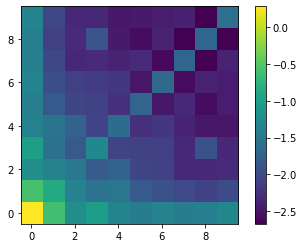

In [34]:
img = plt.imshow(utility_map, origin="lower")
plt.colorbar(img)

# including phase

In [15]:
# testing evidence calculation
w_1 = 1
w_2 = 3
sigma = 0.1
phase = 1
t = np.linspace(0,2*np.pi,500)[[200,400]]
rng = np.random.RandomState(seed=1)
wp = rng.uniform(w_1, w_2)
y_k = generate_data(wp,phase,t,sigma,rng)
evidence, err = dblquad(evidence_integrand, 0, 2*np.pi, w_1, w_2, args=(y_k,t,sigma,w_1,w_2))
print(evidence,err)

0.2644634956342812 1.3777064166769444e-08


In [16]:
def Uy_2D(y_k, t, sigma, w_1, w_2, evidence, prior_integral):
    return -dblquad(utility_integrand, 0, 2*np.pi, w_1, w_2, args=(y_k,t,sigma,w_1,w_2,evidence))[0] + prior_integral

In [17]:
# testing Uy calculation
w_1 = 1
w_2 = 3
sigma = 0.1
i = [200,400]
t = np.linspace(0,2*np.pi,500)[i]
rng = np.random.RandomState(seed=1)
w_p = rng.uniform(w_1, w_2)
phase_p = rng.uniform(0, 2*np.pi)
y_k = generate_data(w_p,phase_p,t,sigma,rng)
evidence = dblquad(evidence_integrand, 0, 2*np.pi, w_1, w_2, args=(y_k,t,sigma,w_1,w_2))[0]
prior_integral = dblquad(prior_integrand, 0, 2*np.pi, w_1, w_2, args=(w_1,w_2))[0]
Uy_2D(y_k,t,sigma,w_1,w_2,evidence,prior_integral)

-3.4184384121028666

In [18]:
def utility_2D(i, Uy_2D, sigma, w_1, w_2, N, seed=1, nmc=100):
    U_sum = 0.
    rng = np.random.RandomState(seed)
    t = np.linspace(0,2*np.pi,N)[i]
    for i in range(nmc):
        # generate params from prior
        w_p = rng.uniform(w_1, w_2)
        phase_p = rng.uniform(0,2*np.pi)
        # generate data for these params
        y_k = generate_data(w_p,phase_p,t,sigma,rng)
        # evalute per-data utility
        evidence = dblquad(evidence_integrand, 0, 2*np.pi, w_1, w_2, args=(y_k,t,sigma,w_1,w_2))[0]
        U_sum += Uy_2D(y_k,t,sigma,w_1,w_2,evidence,prior_integral)
    U_sum += prior_integral
    return U_sum / nmc

In [19]:
i = [250,150] # indices of time
N = 500
w_1 = 1
w_2 = 3
s = 1
sigma = 0.1
prior_integral = dblquad(prior_integrand, 0, 2*np.pi, w_1, w_2, args=(w_1,w_2))[0]
u = utility_2D(i,Uy_2D,sigma,w_1,w_2,N,s,nmc=20)
print(u)

-3.334974836488803


In [24]:
p = 10
N = 1000
s = 1
w_1 = 1
w_2 = 3
sigma = 0.1
nmc = 20
prior_integral = dblquad(prior_integrand, 0, 2*np.pi, w_1, w_2, args=(w_1,w_2))[0]

x = np.linspace(0, N, p, endpoint=False)
y = np.linspace(0, N, p, endpoint=False)
x2D,y2D = np.meshgrid(x,y)
indices = np.stack((x2D,y2D),axis=2).reshape(-1,2).astype(int)

utility_map_2D = np.zeros((p,p))
for d in indices:
    index = p*d/N
    i = index[0].astype(int)
    j = index[1].astype(int)
    utility_map_2D[i,j] = utility_2D(d,Uy_2D,sigma,w_1,w_2,N,s,nmc)

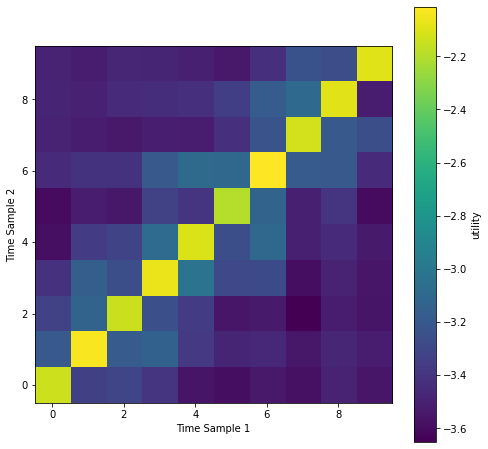

In [25]:
plt.figure(figsize=(8,8))
img_2D = plt.imshow(utility_map_2D, origin="lower")
cbar = plt.colorbar(img_2D)
cbar.set_label("utility")
plt.xlabel("Time Sample 1")
plt.ylabel("Time Sample 2")
plt.show()